## <strong> Filename: </strong> <em>covid_19_time_series_population_infection_rate.ipynb<em>
##### <strong>Description:</strong> <em>COVID-19 Population Infection Rate time series using dataset provided by https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases</em>
##### <strong>Features:</strong> <em> Population Size | Confirmed Cases | PIR </em>
##### <strong>Author:</strong> <em> Carlos Eduardo Beluzo (cbeluzo@gmail.com)</em>
##### <strong>Creation:</strong> <em> Mar/2020 </em>
##### <strong>Version:</strong> <em> 2020.03-1 </em>

/home/cbeluzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning:

divide by zero encountered in true_divide

/home/cbeluzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning:

invalid value encountered in true_divide



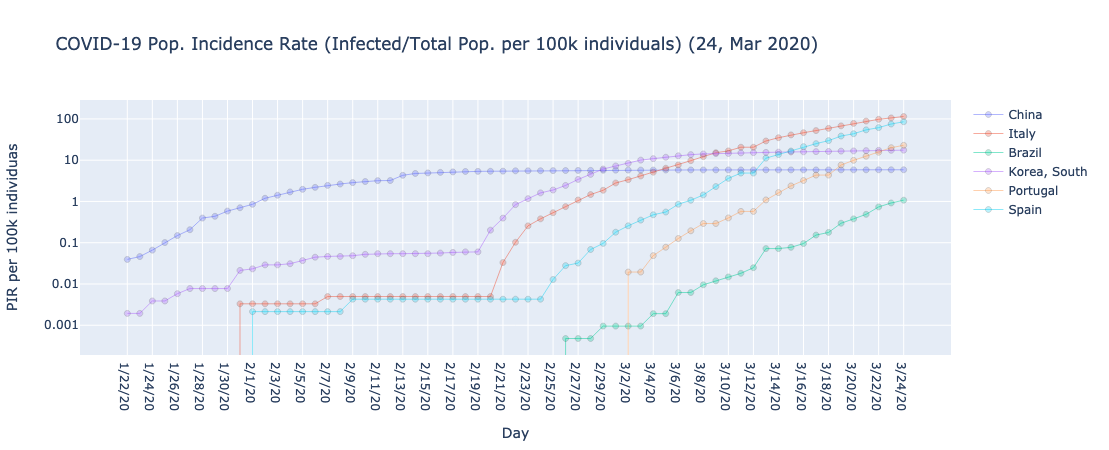

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import plotly as plt
import plotly.express as px
import datetime as dt

# https://data.worldbank.org
dfPop = pd.read_csv('data/world-population-2018.csv', sep=';')

df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df['Province/State'] = df['Province/State'].fillna('n/a')
df = df.fillna(0)

dfA = df.drop(['Province/State','Lat','Long'], axis = 1)
dfA = dfA.groupby('Country/Region').sum().T
dfA = dfA.reset_index()
dfA = dfA.rename(columns = {'index':'Day'})
#dfA[['Day']] = pd.to_datetime(dfA['Day'])

# Calculate rate
dfFinal = dfA.copy()

for country in dfA.columns[1:]:
    dfCountry = pd.DataFrame(dfA[[country]])
    dfAux = pd.DataFrame(dfCountry[country][1:])
    dfAux = dfAux.reset_index()
    dfAux = dfAux.drop(['index'], axis=1)
    dfAux = dfAux.append({country : 0} , ignore_index=True)
    dfCountry['next'] = dfAux
    dfAux['ori'] = dfCountry[country]
    dfCountry['rate'] = np.array((100 * dfAux[country].values / dfAux['ori'].values) - 100)
    dfCountry.loc[dfCountry['rate'] == -100] = 0
    dfCountry.loc[dfCountry['rate'] == np.inf] = 0
    dfCountry = dfCountry.fillna(0)
    rate = str('rate'+'_'+country)
    dfFinal[rate] = dfCountry['rate']

#dfFinal[['Brazil','rate_Brazil']].tail()

# Calculate Population Infection Rate per 100k individuas
df1 = pd.DataFrame({'Day':'','country':'','cases':int(),'rate':float(),'pop':int()}, index=[1])
df1 = df1.drop(df1.index)

for country in dfA.columns[1:]:
    rate = str('rate' + '_' + country)
    
    try:
        pop = dfPop[dfPop['country'] == country]['pop'].values[0]
    except:
        pop = 0
    
    dfAux = pd.DataFrame(dfFinal[['Day',country,country,rate,rate]])
    dfAux.columns = ['Day','country','cases','rate','pop']
    dfAux['country'] = country
    dfAux['pop'] = pop
    df1 = df1.append(dfAux)

df1 = df1.reset_index()
df1 = df1.drop(['index'], axis=1)
#df1[['Day']] = df1['Day'].dt.strftime('%y%m%d')

# Contagion rate per 100k habitants
df1['infection_rate'] = 100000 * df1['cases']/df1['pop']

#df1.loc[df1.country == 'Brazil'].tail()
#dfFinal[['Brazil','rate_Brazil']].tail()

# Graph
fig = go.Figure()

last_upt = dt.date.today() - dt.timedelta(days=1)

title = 'COVID-19 Pop. Incidence Rate (Infected/Total Pop. per 100k individuals) (' + "{:%d, %b %Y}".format(last_upt) +')'
autor = 'Author: Prof. Carlos Ed Beluzo - cbeluzo@gmail.com'
data_source= 'Data source: data.humdata.org, data.worldbank.org'

for country in df1.country.unique():
#for country in ['China','Italy','Brazil','Korea, South','Portugal','Spain']:
    dfA = df1[df1['country'] == country]
    fig.add_trace(go.Scatter(x=dfA.Day,
                             y=dfA.infection_rate,
                             mode='lines+markers',
                             name=country, 
                             line=dict(width=0.5),
                             marker = dict(opacity= 0.3,
                                           line = dict(width = 0.5,
                                                       color = 'rgb(0, 0, 0)')
                                          ),
                             customdata=dfA.cases,
                             text=np.full((df1.shape[0],1), country), 
                             hovertemplate = "<b>%{text}</b><br>" +
                                             "<b>Day</b>: %{x}<br>" +
                                             "<b>PIR</b>: %{y:2f} cases for each 100k<br>" +
                                             "<b>Confirmed cases</b>: %{customdata}<br>" +
                                             "<extra></extra>"
                             )
                 )
    
    
annotations = []

fig.update_layout(annotations=annotations,
                  xaxis_title='Day',
                  yaxis_title='PIR per 100k individuas',
                  yaxis_type="log",
                  title_text=title)

#fig.show()
plt.offline.plot(fig, filename="html/covid_19_time_series_population_infection_rate.html")
dfA.to_csv (r'data/covid_19_time_series_population_infection_rate.csv', index = False, header=True)
